In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Fri_Jan__6_16:45:21_PST_2023
Cuda compilation tools, release 12.0, V12.0.140
Build cuda_12.0.r12.0/compiler.32267302_0


In [2]:
!python3 --version

Python 3.10.12


In [3]:
!nvidia-smi

Sat Sep 21 12:36:54 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.107.02             Driver Version: 550.107.02     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1060        Off |   00000000:01:00.0 Off |                  N/A |
| N/A   68C    P2             26W /   78W |    6027MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Api

In [6]:
import time
import numpy as np
import os
import _pickle as cPickle
import numpy as np
import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import label_to_name as IMAGENET_CLASS_NAMES
import pycuda.autoinit
import pycuda.driver as drv
import numpy
from PIL import Image
import imagehash

from pycuda.compiler import SourceModule

PATH = "../data/cifar-10-batches-py/"
#IMAGENET_PATH = "../data/Imagenet32_train/"

In [7]:
def unpickleImages(pairs):
    images = set()
    for elem in pairs:
        images.add(elem[0])
        images.add(elem[1])

    return list(images)

def load_batch(batchFile):
    f = open(PATH+batchFile, 'rb')
    
    dict_ = cPickle.load(f, encoding='latin1')
    images = dict_['data']
    labels = dict_['labels']
    imagearray = np.array(images)   #   (10000, 3072)
    labelarray = np.array(labels)   #   (10000,)
    
    return imagearray, labelarray

def load_classes():
    file = 'batches.meta'
    
    f = open(PATH+file, 'rb')
    dict = cPickle.load(f)
    return dict['label_names']

In [8]:
unpickleImages([(1,2, 0.85),(3,4,0.34)])

[1, 2, 3, 4]

In [9]:
CIFAR_IMAGES, CIFAR_LABELS = load_batch("data_batch_1")
CIFAR_CLASS_NAMES = load_classes()
CIFAR_IMAGES.shape

(10000, 3072)

In [10]:
def calculate_signature_np(image_file: np.array, hash_size: int) -> np.ndarray:
    pil_image = Image.fromarray(image_file).convert("L").resize(
                        (hash_size+1, hash_size),
                        Image.LANCZOS)
    dhash = imagehash.dhash(pil_image, hash_size)
    signature = dhash.hash.flatten()
    pil_image.close()
    return signature

In [11]:
from typing import List, Dict, Tuple

class cuPerceptual:
    def __init__(self, size, hash_size):
        self.buckets = []
        self.bandsNumber = size
        self.rows = int(hash_size**2 / self.bandsNumber)
        self.hash_buckets_list: List[Dict[int, List[str]]] = [dict() for _ in range(self.bandsNumber)]
        self.signatures = dict()
        self.hash_size = hash_size

        for i in range(size):
            self.buckets.append({})
            
    def fill_buckets(self, signature, idx):  # shingels
        for i in range(self.bandsNumber):
            signature_band = signature[i*self.rows:(i+1)*self.rows]
            signature_band_bytes = signature_band.tobytes()
            if signature_band_bytes not in self.hash_buckets_list[i]:
                self.hash_buckets_list[i][signature_band_bytes] = list()
            self.hash_buckets_list[i][signature_band_bytes].append(idx)
    
    def compute_hash(self, images):
        idx = 0;
        for image in images:
            signature = calculate_signature_np(image.T, self.hash_size)
            self.signatures[idx] = np.packbits(signature.astype(np.uint8))
            self.fill_buckets(signature, idx)
            idx+=1
        return self.signatures

    def compute_candidate(self):
        candidate_pairs = set()
        
        for hash_buckets in self.hash_buckets_list:
            for hash_bucket in hash_buckets.values():
                if len(hash_bucket) > 1:
                    hash_bucket = sorted(hash_bucket) # Why needed ?
                    for i in range(len(hash_bucket)):
                        for j in range(i+1, len(hash_bucket)):
                            candidate_pairs.add(
                                tuple([hash_bucket[i],hash_bucket[j]])
                            )
        return candidate_pairs

    def check_candidate(self, candidate_pairs, threshold=0.9):
        
        near_duplicates = list()
        for cpa, cpb in candidate_pairs:
            hd = sum(np.bitwise_xor(
                    np.unpackbits(self.signatures[cpa]), 
                    np.unpackbits(self.signatures[cpb])
            ))
            similarity = (self.hash_size**2 - hd) / self.hash_size**2
            if similarity > threshold:
                near_duplicates.append((cpa, cpb, similarity))
                
        # Sort near-duplicates by descending similarity and return
        near_duplicates.sort(key=lambda x:x[2], reverse=True)
        return near_duplicates

    def recheck_candidate(self, candidate_pairs, threshold=0.9):
        
        near_duplicates = list()
        for cpa, cpb,_ in candidate_pairs:
            hd = sum(np.bitwise_xor(
                    np.unpackbits(self.signatures[cpa]), 
                    np.unpackbits(self.signatures[cpb])
            ))
            similarity = (self.hash_size**2 - hd) / self.hash_size**2
            if similarity > threshold:
                near_duplicates.append((cpa, cpb, similarity))
                
        # Sort near-duplicates by descending similarity and return
        near_duplicates.sort(key=lambda x:x[2], reverse=True)
        return near_duplicates

In [12]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

In [13]:
torch.set_default_device('cuda:0') 

In [14]:
class Net2(nn.Module):
    def __init__(self, bits):
        super().__init__()
        self.fc1 = nn.Linear(2048, 256)
        self.hash1 = nn.Linear(256, bits)
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(bits, 10)

    def forward(self, x):
        x = x.to(torch.float32)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.hash1(x)
        hash_= self.sigmoid(x);
        x = self.fc2(x)
        return x, hash_

HASH_SIZE = 64
net2 = Net2( HASH_SIZE )
net2.to("cuda:0")

Net2(
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (hash1): Linear(in_features=256, out_features=64, bias=True)
  (sigmoid): Sigmoid()
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

In [15]:
from torchvision import models

resnet50 = models.resnet50(pretrained = True) # weights=ResNet50_Weights.DEFAULT
resnet50 = resnet50.to("cuda:0")
resnet50.fc = torch.nn.Identity()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
net2 = Net2( HASH_SIZE ).to("cuda:0")

In [17]:
PATH = "../2.NeuralHashing/mainModel.pth"
model = nn.Sequential(resnet50, net2)
model.load_state_dict(torch.load(PATH))
model = model.eval()

/tmp/ipykernel_1669/180531649.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(PATH))


In [18]:
for param in model.parameters():
    param.requires_grad = False

In [19]:
from typing import List, Dict, Tuple

class cuNN:
    def __init__(self, size, hash_size, images, size_images ):
        self.buckets = []
        self.bandsNumber = size
        self.rows = int(hash_size**2 / self.bandsNumber)
        self.hash_buckets_list: List[Dict[int, List[str]]] = [dict() for _ in range(self.bandsNumber)]
        self.signatures = np.zeros([len(images), hash_size ]).astype(np.float32)
        self.hash_size = hash_size
        self.images = images;
        self.size_ = size_images

        for i in range(size):
            self.buckets.append({})
            
    def fill_buckets(self, signature, idx):
        for i in range(self.bandsNumber):
            signature_band = signature[i*self.rows:(i+1)*self.rows]
            signature_band_bytes = signature_band.tobytes()
            if signature_band_bytes not in self.hash_buckets_list[i]:
                self.hash_buckets_list[i][signature_band_bytes] = list()
            self.hash_buckets_list[i][signature_band_bytes].append(idx)

    def compute_hash(self):
        
        tensor_image = torch.FloatTensor(self.images).to("cuda:0")
        label, hash_ = model(tensor_image)
        signatures = torch.round(hash_).cpu().detach().numpy().astype(np.int8)
        
        idx = 0
        for signature in signatures:
            self.signatures[idx] = np.packbits( signature ).astype(np.float32)
            self.fill_buckets(signature, idx)
            idx+=1
        return self.signatures
    
    def compute_candidate(self):
        candidate_pairs = set()
        #list1 = []
        #list2 = []

        for hash_buckets in self.hash_buckets_list:
            for hash_bucket in hash_buckets.values():
                if len(hash_bucket) > 1:
                    hash_bucket = sorted(hash_bucket)
                    for i in range(len(hash_bucket)):
                        for j in range(i+1, len(hash_bucket)):
                            candidate_pairs.add(
                               tuple([hash_bucket[i], hash_bucket[j]])
                            )
                            #list1.append(self.signatures[hash_bucket[i]]) 
                            #list2.append(self.signatures[hash_bucket[j]]) 
                            #list1.append(hash_bucket[i]) 
                            #list2.append(hash_bucket[j]) 
        return candidate_pairs
        #return list1, list2
    
    def check_candidate(self, candidate_pairs, threshold=0.9):
        near_duplicates = list()
        for cpa, cpb in candidate_pairs:
            item_cpa = np.array(self.signatures[cpa]).astype(np.uint8)
            item_cpb = np.array(self.signatures[cpb]).astype(np.uint8)
            hd = sum(np.bitwise_xor(
                    np.unpackbits(item_cpa), 
                    np.unpackbits(item_cpb)
            ))
            similarity = (self.hash_size**2 - hd) / self.hash_size**2
            if similarity > threshold:
                near_duplicates.append((cpa, cpb, similarity))
                
        # Sort near-duplicates by descending similarity and return
        near_duplicates.sort(key=lambda x:x[2], reverse=True)
        return near_duplicates

    def recheck_candidate(self, candidate_pairs, threshold=0.9):
        near_duplicates = list()
        for cpa, cpb,_ in candidate_pairs:
            item_cpa = np.array(self.signatures[cpa]).astype(np.uint8)
            item_cpb = np.array(self.signatures[cpb]).astype(np.uint8)
            hd = sum(np.bitwise_xor(
                    np.unpackbits(item_cpa), 
                    np.unpackbits(item_cpb)
            ))
            similarity = (self.hash_size**2 - hd) / self.hash_size**2
            if similarity > threshold:
                near_duplicates.append((cpa, cpb, similarity))
                
        # Sort near-duplicates by descending similarity and return
        near_duplicates.sort(key=lambda x:x[2], reverse=True)
        return near_duplicates

In [33]:
from typing import List, Dict, Tuple

class cuNN:
    def __init__(self, size, hash_size, images, size_images ):
        self.buckets = []
        self.bandsNumber = size
        self.rows = int(hash_size**2 / self.bandsNumber)
        self.hash_buckets_list: List[Dict[int, List[str]]] = [dict() for _ in range(self.bandsNumber)]
        self.signatures = np.zeros([len(images), hash_size //8 ]).astype(np.float32)
        self.hash_size = hash_size
        self.images = images;
        self.size_ = size_images

        for i in range(size):
            self.buckets.append({})
            
    def fill_buckets(self, signature, idx):
        for i in range(self.bandsNumber):
            signature_band = signature[i*self.rows:(i+1)*self.rows]
            signature_band_bytes = signature_band.tobytes()
            if signature_band_bytes not in self.hash_buckets_list[i]:
                self.hash_buckets_list[i][signature_band_bytes] = list()
            self.hash_buckets_list[i][signature_band_bytes].append(idx)

    def compute_hash(self):
        for i in range(0, self.images.shape[0], 500):
            tmp_image = self.images[i:i+500]
            tensor_image = torch.FloatTensor(tmp_image).to("cuda:0")
            label, hash_ = model(tensor_image)
            signatures = torch.round(hash_).cpu().detach().numpy().astype(np.int8)
        
            idx = 0
            for signature in signatures:
                self.signatures[idx] = np.packbits( signature ).astype(np.float32)
                self.fill_buckets(signature, idx)
                idx+=1
            return self.signatures
    
    def compute_candidate(self):
        candidate_pairs = set()

        for hash_buckets in self.hash_buckets_list:
            for hash_bucket in hash_buckets.values():
                if len(hash_bucket) > 1:
                    hash_bucket = sorted(hash_bucket)
                    for i in range(len(hash_bucket)):
                        for j in range(i+1, len(hash_bucket)):
                            candidate_pairs.add(
                               tuple([hash_bucket[i], hash_bucket[j]])
                            )
        return candidate_pairs
    
    def check_candidate(self, candidate_pairs, threshold=0.9):
        near_duplicates = list()
        for cpa, cpb in candidate_pairs:
            item_cpa = np.array(self.signatures[cpa]).astype(np.uint8)
            item_cpb = np.array(self.signatures[cpb]).astype(np.uint8)
            hd = sum(np.bitwise_xor(
                    np.unpackbits(item_cpa), 
                    np.unpackbits(item_cpb)
            ))
            similarity = (self.hash_size**2 - hd) / self.hash_size**2
            if similarity > threshold:
                near_duplicates.append((cpa, cpb, similarity))
                
        # Sort near-duplicates by descending similarity and return
        near_duplicates.sort(key=lambda x:x[2], reverse=True)
        return near_duplicates

    def recheck_candidate(self, candidate_pairs, threshold=0.9):
        near_duplicates = list()
        for cpa, cpb,_ in candidate_pairs:
            item_cpa = np.array(self.signatures[cpa]).astype(np.uint8)
            item_cpb = np.array(self.signatures[cpb]).astype(np.uint8)
            hd = sum(np.bitwise_xor(
                    np.unpackbits(item_cpa), 
                    np.unpackbits(item_cpb)
            ))
            similarity = (self.hash_size**2 - hd) / self.hash_size**2
            if similarity > threshold:
                near_duplicates.append((cpa, cpb, similarity))
                
        # Sort near-duplicates by descending similarity and return
        near_duplicates.sort(key=lambda x:x[2], reverse=True)
        return near_duplicates

In [34]:
IMG = CIFAR_IMAGES[0:10000].reshape(10000,3,32,32)
LABELS = CIFAR_LABELS
print(IMG.shape)

(10000, 3, 32, 32)


In [36]:
nnLSH = cuNN(8, 64, IMG, len(IMG))
#nnLSH = cuNN(16, 8, IMG, len(IMG))
#nnLSH = cuNN(8, 8, IMG, len(IMG))
signatures = nnLSH.compute_hash()
print(signatures.shape)

pairs = nnLSH.compute_candidate()
print(len(pairs))

duplicates = nnLSH.check_candidate(pairs, 0.9)
print(len(duplicates))

perceptualLSH = cuPerceptual(8, 8)
perceptualLSH.compute_hash(IMG)
duplicates2 = perceptualLSH.recheck_candidate(duplicates,0.9)
print(len(duplicates2))


(10000, 8)
124750
124750
0


IndexError: list index out of range

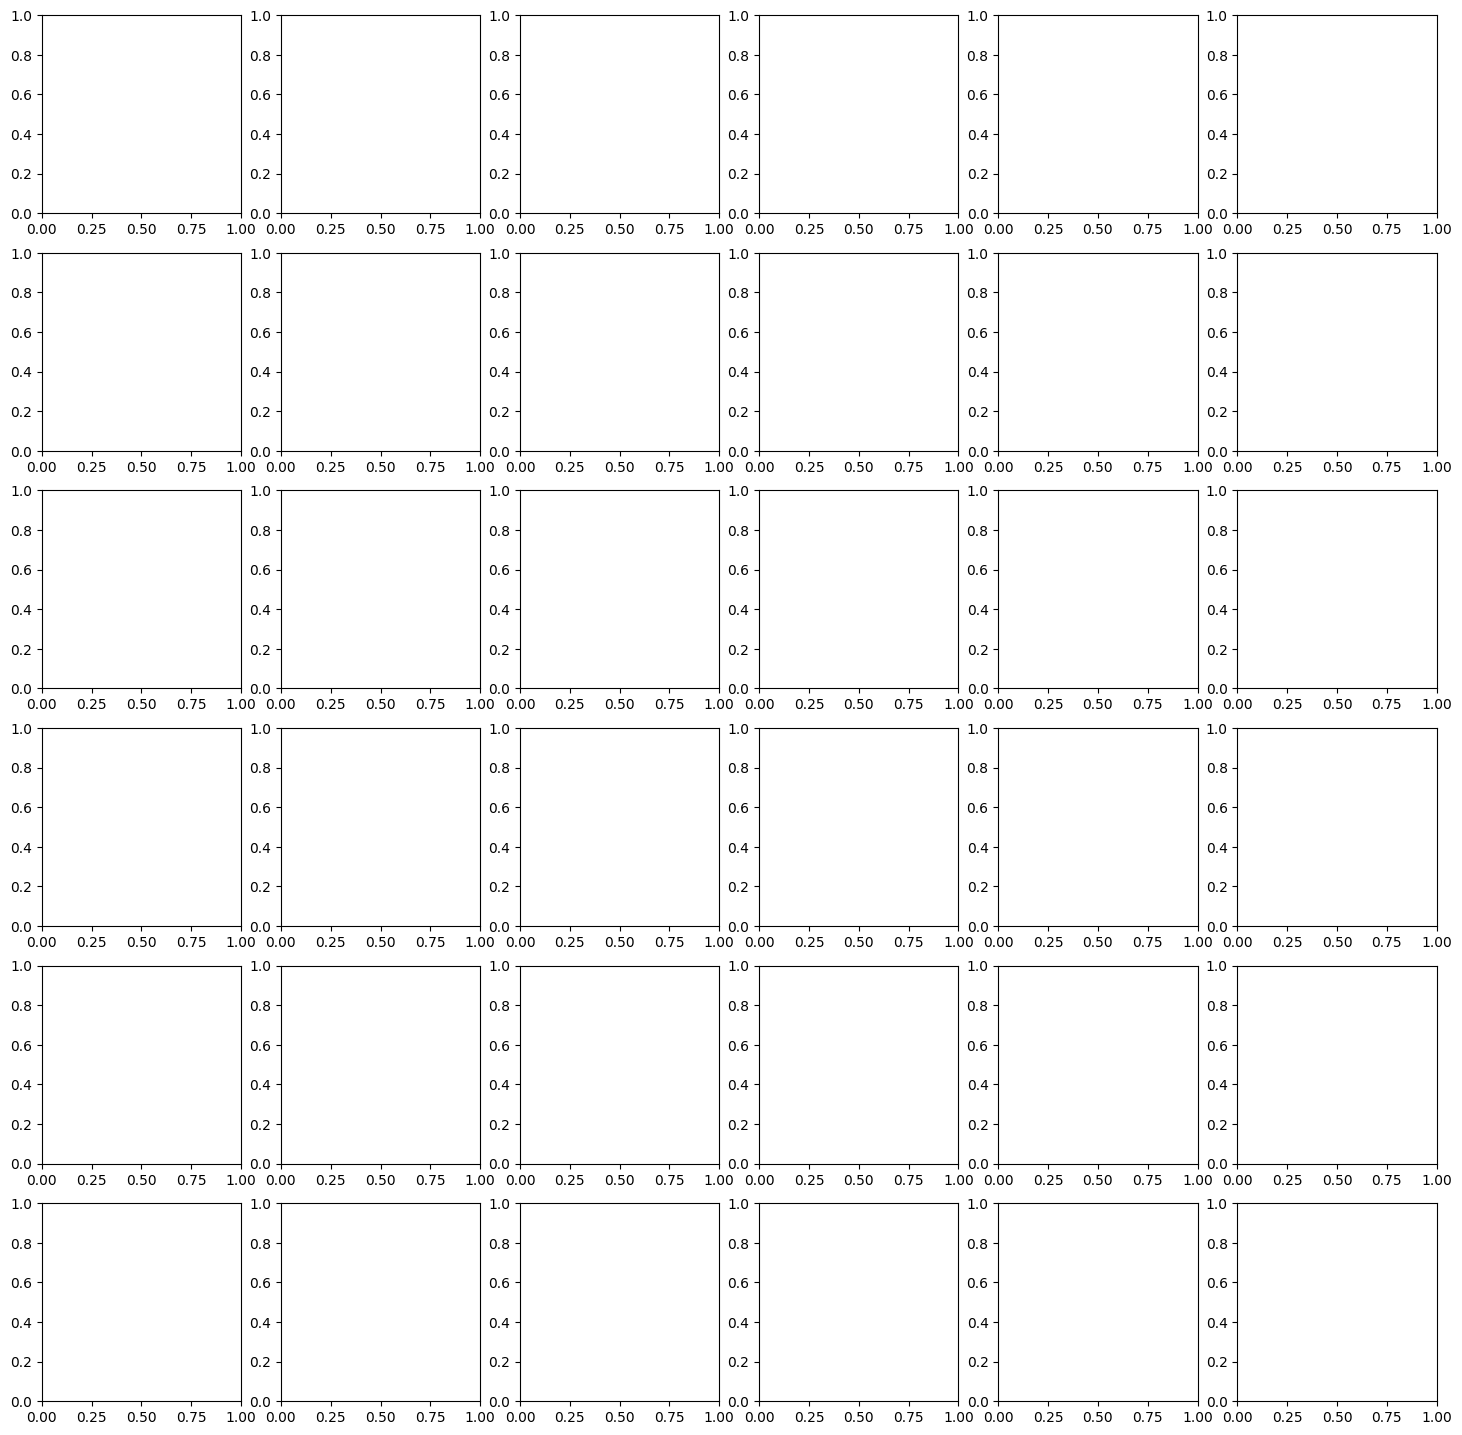

In [24]:
from matplotlib import pyplot as plt

num_row = 6
num_col = 6
col_idx = 0
row_idx = 0

idx_start = 0;

fig, axes = plt.subplots(num_row, num_col, figsize=(3*num_col,3*num_row))
for i in range(0, num_row*num_col//2, 1):
    if col_idx >= num_col -1:
        col_idx = 0
        row_idx += 1
    
    ax = axes[row_idx, col_idx]
    ax.imshow(IMG[duplicates2[i + idx_start ][0]].reshape(3,32,32).T)
    ax.set_title(f"""Label: {duplicates2[i + idx_start ][0]}, {CIFAR_LABELS[duplicates2[i + idx_start ][0]]}, {duplicates2[i + idx_start][2]}""")

    col_idx += 1
    ax = axes[row_idx, col_idx]
    ax.imshow(IMG[duplicates2[i + idx_start][1]].reshape(3,32,32).T)
    ax.set_title(f"""Label: {duplicates2[i + idx_start][1]}, {CIFAR_LABELS[duplicates2[i + idx_start][1]]}, {duplicates2[i + idx_start][2]}""")
    col_idx += 1

plt.tight_layout()
plt.xticks([])
plt.yticks([])

plt.show()

In [ ]:
withoutLastElements = 0#577600
sumTrueDuplicates = 0
for i in range( len(duplicates) - withoutLastElements ):
    if LABELS[duplicates[i][0]] == LABELS[duplicates[i][1]]:
        sumTrueDuplicates += 1
        

print("True duplicates: ", sumTrueDuplicates)
print("All duplicates: ", len(duplicates) - withoutLastElements )
acc = sumTrueDuplicates / ( len(duplicates) - withoutLastElements )
print(acc)

In [ ]:
withoutLastElements = 0#577600
sumTrueDuplicates = 0
for i in range( len(duplicates2) - withoutLastElements ):
    if LABELS[duplicates2[i][0]] == LABELS[duplicates2[i][1]]:
        sumTrueDuplicates += 1
        

print("True duplicates: ", sumTrueDuplicates)
print("All duplicates: ", len(duplicates2) - withoutLastElements )
acc = sumTrueDuplicates / ( len(duplicates2) - withoutLastElements )
print(acc)

### Second 

In [45]:
perceptualLSH = cuPerceptual(8, 8)
perceptualLSH.compute_hash(IMG)
pairs3 = perceptualLSH.compute_candidate()
duplicates3 = perceptualLSH.check_candidate(pairs3,0.9)
print(len(duplicates3))

nnLSH = cuNN(16, 8, IMG, len(IMG))
signatures4 = nnLSH.compute_hash()
duplicates4 = nnLSH.recheck_candidate(duplicates3, 0.9)
print(len(duplicates4))


127
117


In [46]:
# Treshold wwazny zeby odfiltrowac nie duplikaty
# Porownywanie duplikatow zdjec - przy podwojnym filtrowaniu ???
# 6 milionow par potencjalych przy sieci neuronowej
# Pierw musi chodzic PyCUDA poniej doperio cos PyTorch, zeby nie bylo przeklama w dostepie do cuda

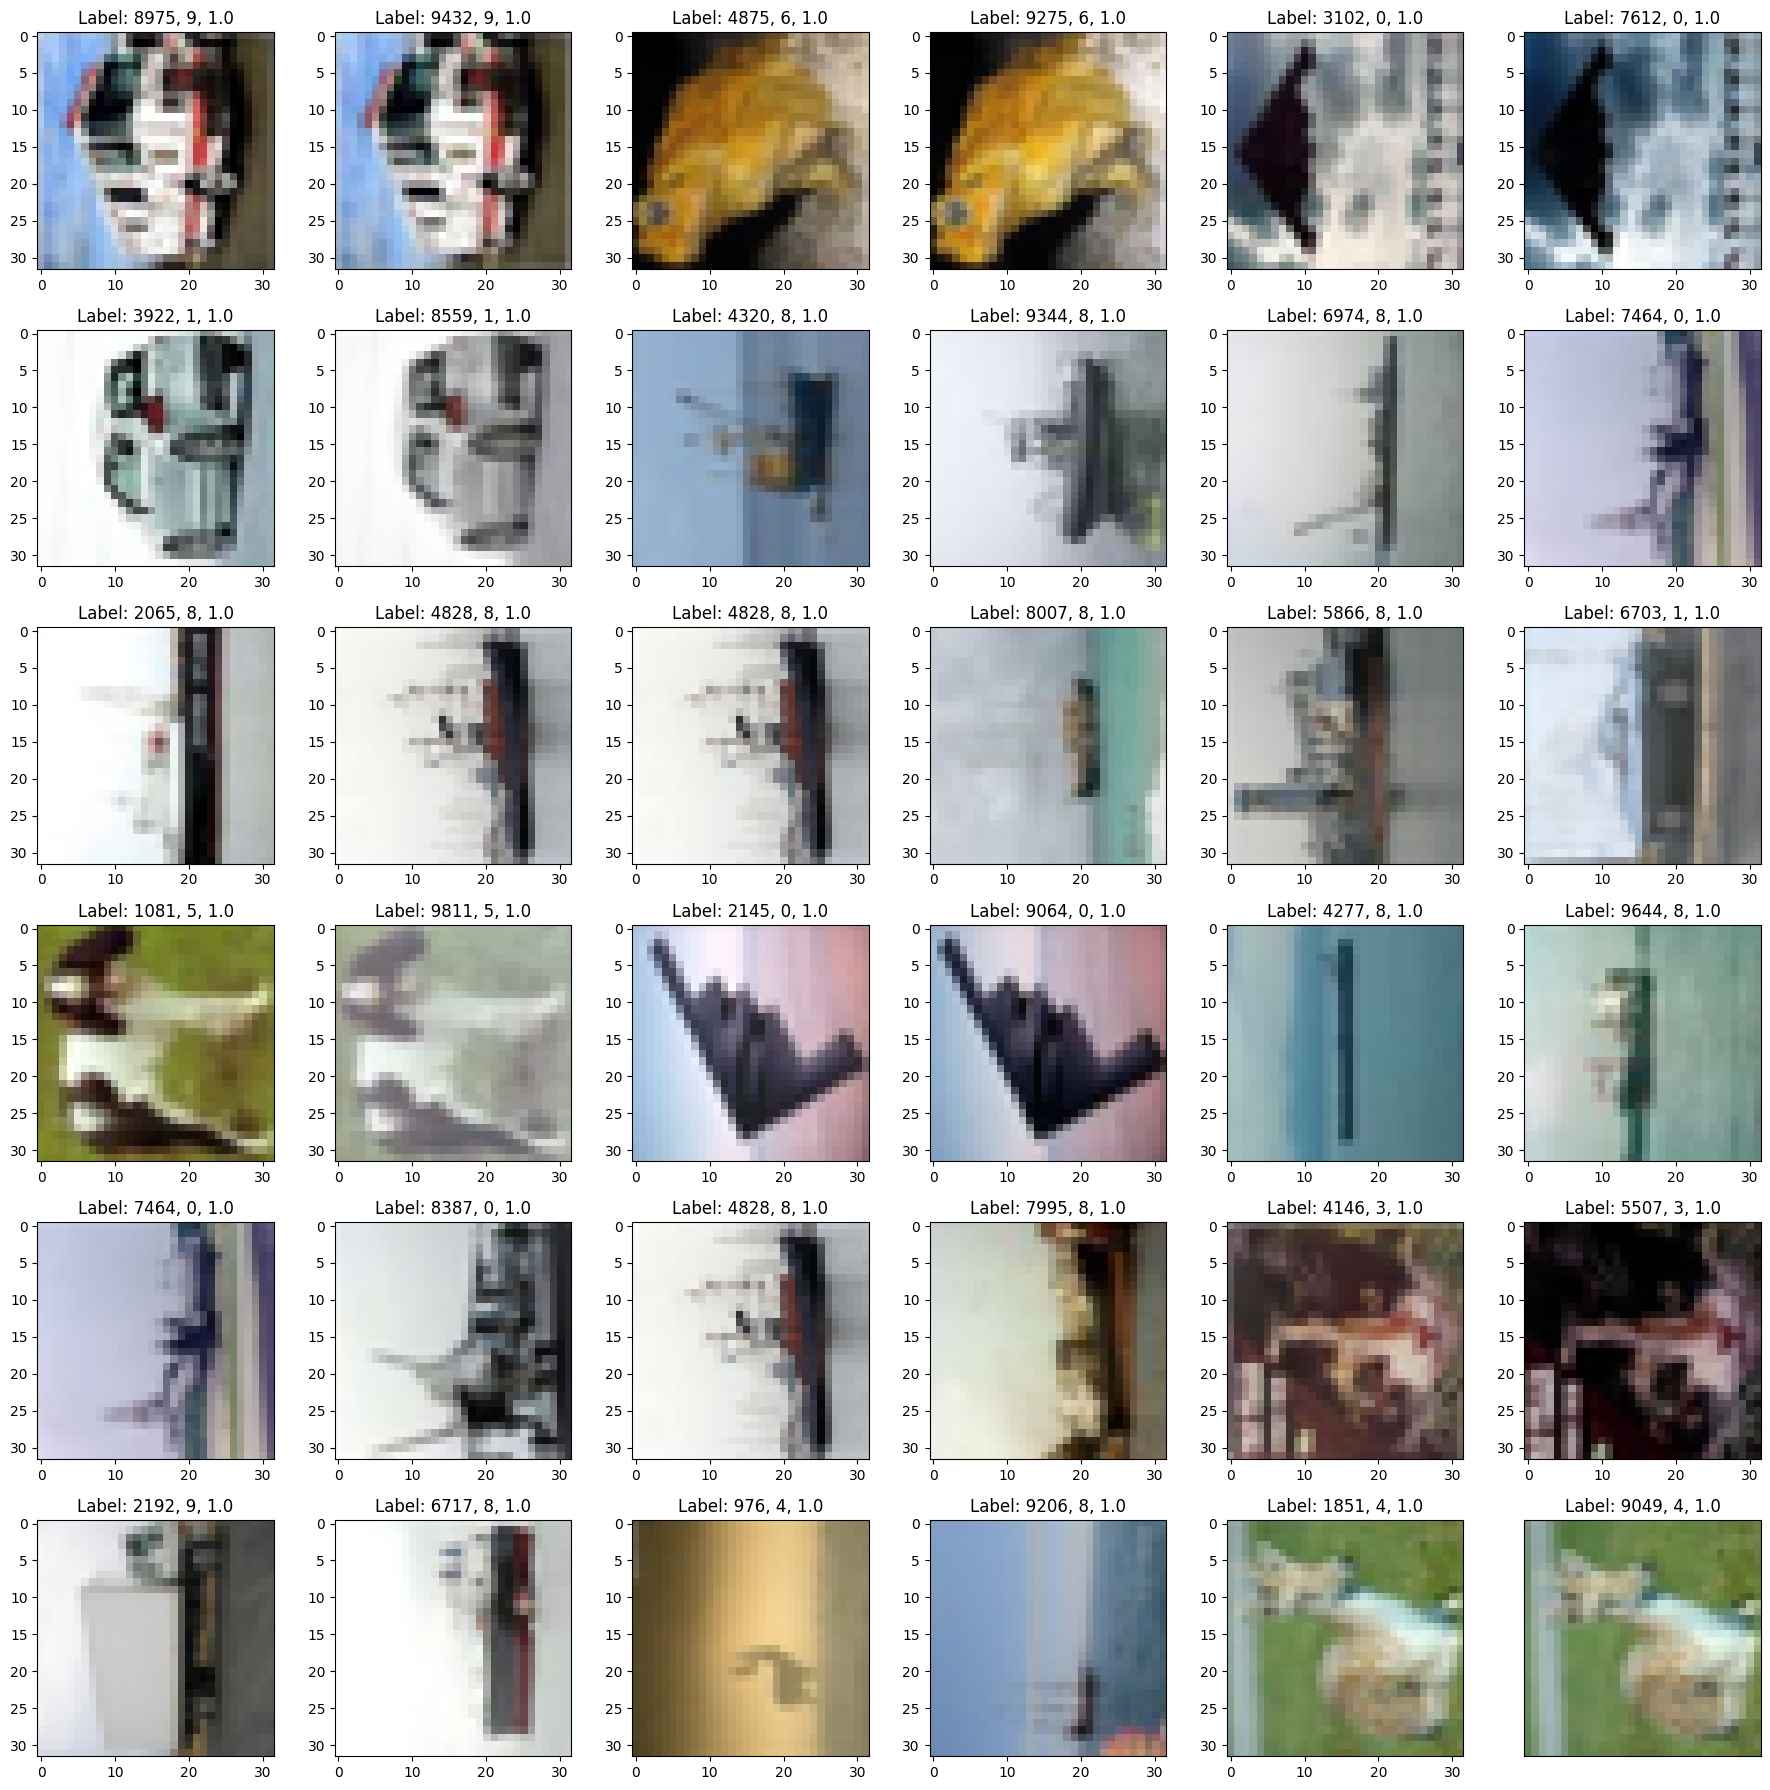

In [47]:
from matplotlib import pyplot as plt

num_row = 6
num_col = 6
col_idx = 0
row_idx = 0

idx_start = 0;

fig, axes = plt.subplots(num_row, num_col, figsize=(3*num_col,3*num_row))
for i in range(0, num_row*num_col//2, 1):
    if col_idx >= num_col -1:
        col_idx = 0
        row_idx += 1
    
    ax = axes[row_idx, col_idx]
    ax.imshow(CIFAR_IMAGES[duplicates4[i + idx_start ][0]].reshape(3,32,32).T)
    ax.set_title(f"""Label: {duplicates4[i + idx_start ][0]}, {CIFAR_LABELS[duplicates4[i + idx_start ][0]]}, {duplicates4[i + idx_start][2]}""")

    col_idx += 1
    ax = axes[row_idx, col_idx]
    ax.imshow(CIFAR_IMAGES[duplicates4[i + idx_start][1]].reshape(3,32,32).T)
    ax.set_title(f"""Label: {duplicates4[i + idx_start][1]}, {CIFAR_LABELS[duplicates4[i + idx_start][1]]}, {duplicates4[i + idx_start][2]}""")
    col_idx += 1

plt.tight_layout()
plt.xticks([])
plt.yticks([])

plt.show()

In [48]:
withoutLastElements = 0#577600
sumTrueDuplicates = 0
for i in range( len(duplicates3) - withoutLastElements ):
    if LABELS[duplicates3[i][0]] == LABELS[duplicates3[i][1]]:
        sumTrueDuplicates += 1
        

print("True duplicates: ", sumTrueDuplicates)
print("All duplicates: ", len(duplicates3) - withoutLastElements )
acc = sumTrueDuplicates / ( len(duplicates3) - withoutLastElements )
print(acc)

True duplicates:  75
All duplicates:  127
0.5905511811023622


In [49]:
withoutLastElements = 0#577600
sumTrueDuplicates = 0
for i in range( len(duplicates4) - withoutLastElements ):
    if LABELS[duplicates4[i][0]] == LABELS[duplicates4[i][1]]:
        sumTrueDuplicates += 1
        

print("True duplicates: ", sumTrueDuplicates)
print("All duplicates: ", len(duplicates4) - withoutLastElements )
acc = sumTrueDuplicates / ( len(duplicates4) - withoutLastElements )
print(acc)

True duplicates:  70
All duplicates:  117
0.5982905982905983
